# Time-Delay Filters

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pylab as plt

import WDM
from WDM.code.discrete_wavelet_transform import WDM
from WDM.code.time_delay_filters.filters import time_delay_filter_Tl, time_delay_filter_Tprimel, time_delay_X

In [2]:
dt = 1.0

Nt = 32
Nf = 16
N = Nt*Nf

wdm = WDM.WDM_transform(dt=dt, Nf=Nf, N=N, q=8, calc_m0=True)

Plot the time-delay filter functions

$$ T_\ell(\delta t) = \int\mathrm{d}f\exp(2\pi i f(\ell\Delta T-\delta t)) 
                            |\tilde{\Phi}(f)|^2$$

$$ T'_\ell(\delta t) = \int\mathrm{d}f\exp(2\pi i f(\ell\Delta T-\delta t)) 
                            \tilde{\Phi}\left(f-\frac{1}{2}\Delta F\right)
                            \tilde{\Phi}\left(f+\frac{1}{2}\Delta F\right)$$

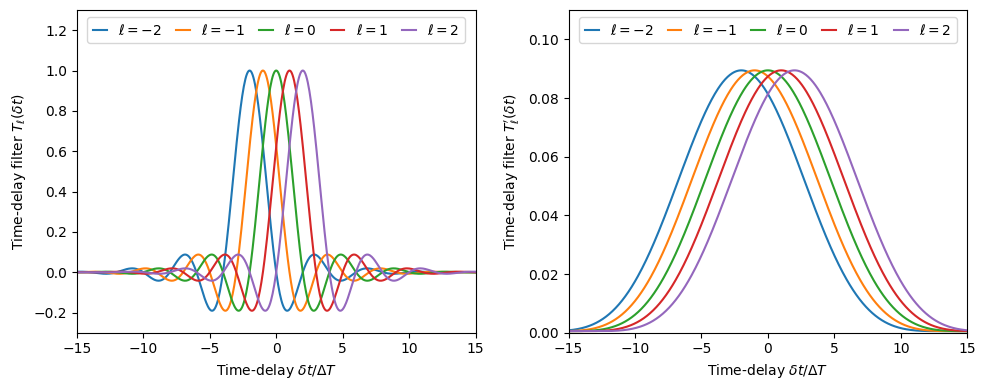

In [ ]:
delta_t_vals = jnp.linspace(-15*wdm.dT, 15*wdm.dT, 500)

Tl_vals = {}
Tprimel_vals = {}

ell_max = 2

for ell in range(-ell_max, ell_max+1):
    Tl_vals[ell] = jnp.array([time_delay_filter_Tl(wdm, ell, delta_t) for delta_t in delta_t_vals])
    Tprimel_vals[ell] = jnp.array([time_delay_filter_Tprimel(wdm, ell, delta_t) for delta_t in delta_t_vals])

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

for ell in range(-ell_max, ell_max+1):
    axes[0].plot(delta_t_vals/wdm.dT, Tl_vals[ell], label=r'$\ell={}$'.format(ell))
    axes[1].plot(delta_t_vals/wdm.dT, Tprimel_vals[ell], label=r'$\ell={}$'.format(ell))

axes[0].set_xlim(delta_t_vals[0]/wdm.dT, delta_t_vals[-1]/wdm.dT)
axes[0].set_xlabel(r'Time-delay $\delta t/\Delta T$')

axes[1].set_xlim(delta_t_vals[0]/wdm.dT, delta_t_vals[-1]/wdm.dT)
axes[1].set_xlabel(r'Time-delay $\delta t/\Delta T$')

axes[0].set_ylim(-0.3, 1.3)
axes[0].set_ylabel(r'Time-delay filter $T_\ell(\delta t)$')

axes[1].set_ylim(0, 0.11)
axes[1].set_ylabel(r'Time-delay filter $T^\prime_\ell(\delta t)$')

axes[0].legend(ncols=5, loc='upper center', handlelength=1, columnspacing=1)
axes[1].legend(ncols=5, loc='upper center', handlelength=1, columnspacing=1)
plt.tight_layout()
plt.show()

Show how to use the $X$ coefficients

$$ X_{nn';mm'}(\delta t) = \int\mathrm{d}t g_{nm}(t+\delta t)g^*_{n'm'}(t) $$

to time shift a wavelet.

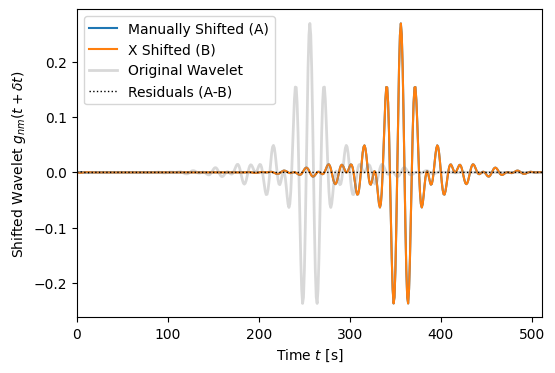

In [22]:
# pick a wavelet
n, m = 16, 2
g = wdm.gnm(n, m)

# manually time shift the wavelet
delta_t = 100.
from scipy.interpolate import interp1d
g_shifted = interp1d(wdm.times, g, kind='cubic', bounds_error=False, fill_value=0.0)(wdm.times-delta_t)

# reconstruct the time-shifted wavelet using the X coefficients
g_reconstructed = jnp.zeros_like(g)
for n_ in range(0, wdm.Nt):
    for m_ in [m-1, m, m+1]:
        X = time_delay_X(wdm, n, n_, m, m_, -delta_t)
        g_reconstructed += X * wdm.gnm(n_, m_)


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wdm.times, g_shifted, label='Manually Shifted (A)')
ax.plot(wdm.times, g_reconstructed, label='X Shifted (B)')
ax.plot(wdm.times, g, label='Original Wavelet', c='gray', ls='-', lw=2, alpha=0.3)
ax.plot(wdm.times, g_shifted-g_reconstructed, 'k:', lw=1, label='Residuals (A-B)')
ax.set_xlim(wdm.times[0], wdm.times[-1])
ax.set_xlabel(r'Time $t$ [s]')
ax.set_ylabel(r'Shifted Wavelet $g_{nm}(t+\delta t)$')
ax.legend()
plt.show()

Note that when the $X$ coefficients are used to time shift the wavelet basis 
the wavelets wrap around circularly in the array.

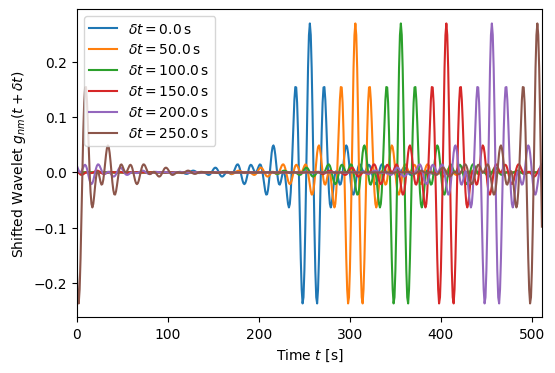

In [28]:
# pick a wavelet
n, m = 16, 2
g = wdm.gnm(n, m)

# reconstruct the time-shifted wavelet using the X coefficients
delta_t_vals = [0., 50., 100., 150., 200., 250.]
g_reconstructed = {}
for i, delta_t in enumerate(delta_t_vals):
    g_reconstructed[i] = jnp.zeros_like(g)
    for n_ in range(0, wdm.Nt):
        for m_ in [m-1, m, m+1]:
            X = time_delay_X(wdm, n, n_, m, m_, -delta_t)
            g_reconstructed[i] += X * wdm.gnm(n_, m_)


fig, ax = plt.subplots(figsize=(6, 4))
for i, delta_t in enumerate(delta_t_vals):
    ax.plot(wdm.times, g_reconstructed[i], label=fr'$\delta t={delta_t}\,$s')
ax.set_xlim(wdm.times[0], wdm.times[-1])
ax.set_xlabel(r'Time $t$ [s]')
ax.set_ylabel(r'Shifted Wavelet $g_{nm}(t+\delta t)$')
ax.legend()
plt.show()